# SEC Filings

The data is provided in zipped text files. Unzip the file and place the 'SEC-filings' directory into the './data' directory. 

A related dataset in similar format is the conll2003 dataset, available from [HuggingFace](https://huggingface.co/datasets/conll2003). This could be used as a source of additional training data, but note it contains a different kind of text (different 'domain'). 

In [1]:
%load_ext autoreload
%autoreload 2

# Data Extraction
import sys
sys.path.append('..')

import data_loader
import warnings
import functions as f
import params as p
import eli5
import seaborn as sns
from string import punctuation

# Other
import matplotlib.pyplot as plt
import nltk
from sklearn.exceptions import UndefinedMetricWarning
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

import optuna

/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Settings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action = 'ignore', category = UndefinedMetricWarning)

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import Data

In [3]:
(
    train_sentences_ner, train_labels_ner, test_sentences_ner, test_labels_ner, val_sentences_ner, val_labels_ner,
    ) = data_loader.import_task2_data()

Loading the original training set: 
Number of sentences loaded = 1152
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']

Loading the test set: 
Number of sentences loaded = 303
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']


# Task 2 Answer

### Clean and Process Data

In [4]:
def crf_word_preprocessing(word, ref):

    word_features = {
        'bias' : 1,
        f'word{ref}_lower' : word.lower(),
        f'word{ref}_end3' : word[-3:],
        f'word{ref}_end2' : word[-2:],
        f'word{ref}_beg' : word[:3],
        f'word{ref}_isupper' : word.isupper(),
        f'word{ref}_istitle' : word.istitle(),
        f'word{ref}_isdigit' : word.isdigit(),
        f'word{ref}_ispunctuation' : word in punctuation,
        f'word{ref}_isstopword' : word in nltk.corpus.stopwords.words('english'),
        f'word{ref}_postag' : nltk.pos_tag([word])[0][1],
        }

    return word_features

In [5]:
def crf_sentence_preprocessing(sentence):

    sentence_features = []

    for idx in range(len(sentence)):

        word = sentence[idx]

        word_features = crf_word_preprocessing(word, 0)

        if idx > 0:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx - 1], -1)
                }
        else:
            word_features['BOS'] = True

        if idx < len(sentence) - 1:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx + 1], +1)
            }
        else:
            word_features['EOS'] = True

        sentence_features.append(word_features)

    return sentence_features

In [6]:
def crf_data_preprocessing(data):
    opt = [crf_sentence_preprocessing(sentence) for sentence in data]
    print('data:', len(data), 'out:', len(opt))
    return opt

### Preprocess Data

In [7]:
X_train = crf_data_preprocessing(train_sentences_ner)
X_test = crf_data_preprocessing(test_sentences_ner)
X_val = crf_data_preprocessing(val_sentences_ner)

data: 864 out: 864
data: 303 out: 303
data: 288 out: 288


### NER Modelling

In [11]:
base_crf = CRF()
base_crf.fit(
    X = X_train,
    y = train_labels_ner,
)

CRF(keep_tempfiles=None)

In [16]:
f.evaluate_model(
    base_crf,
    X_train = X_train,
    X_val = X_val,
    y_train = train_labels_ner,
    y_val = val_labels_ner,)

Train         0.976994
Validation    0.802105
Name: F1 Score, dtype: float64

### Basic Tuning

In [20]:
c2_params = [0.1, 0.01, 0.001, 0.0001]

for c2 in c2_params:

    tuning_crf = CRF(
        c1 = 1,
        c2 = c2
        ).fit(X_train, train_labels_ner)

    evaluate = f.evaluate_model(
        tuning_crf,
        X_train = X_train,
        X_val = X_val,
        y_train = train_labels_ner,
        y_val = val_labels_ner,)

    print(f'c2: {c2}; train/test f1: {evaluate.loc[:, "F1 Score"].values}')

c2: 0.1; train/test f1: [0.9025036  0.83709574]
c2: 0.01; train/test f1: [0.91062764 0.85469132]
c2: 0.001; train/test f1: [0.9169519  0.85265549]
c2: 0.0001; train/test f1: [0.9169519  0.85265549]


In [21]:
tuned_crf = CRF(
    c1 = 1,
    c2 = 0.01
)

tuned_crf.fit(X_train, train_labels_ner)

CRF(c1=1, c2=0.01, keep_tempfiles=None)

### Evaluate Final Model

In [22]:
eval_results = f.evaluate_model(
    tuned_crf,
    X_train = X_train,
    X_val = X_val,
    y_train = train_labels_ner,
    y_val = val_labels_ner,
    X_test = X_test,
    y_test = test_labels_ner)

eval_results

,F1 Score,Accuracy,Precision,Recall
Train,0.910628,0.994595,0.980444,0.857904
Validation,0.854691,0.989931,0.951616,0.779703
Test,0.695791,0.985356,0.857593,0.610092


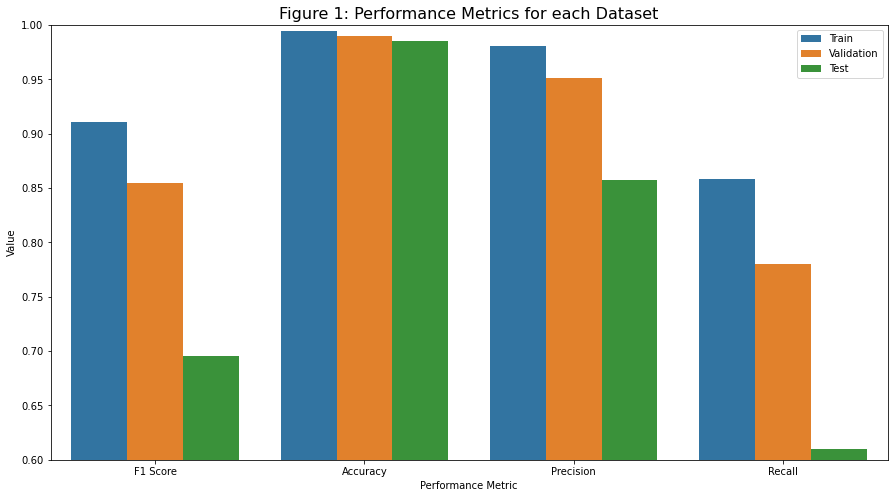

In [23]:
melt_data = eval_results.reset_index().melt(id_vars = 'index')

fig, ax = plt.subplots(1,1,figsize=(15, 8))

sns.barplot(
    ax = ax,
    data = melt_data,
    x = 'variable',
    y = 'value',
    hue = 'index'
).set(label = 'Datasets')

plt.legend(loc = 'upper right')
plt.xlabel('Performance Metric')
plt.ylabel('Value')
plt.ylim(0.6, 1)
plt.title('Figure 1: Performance Metrics for each Dataset', fontsize = 16)
plt.savefig('./final_metrics.png')
plt.show()

### Displaying Results

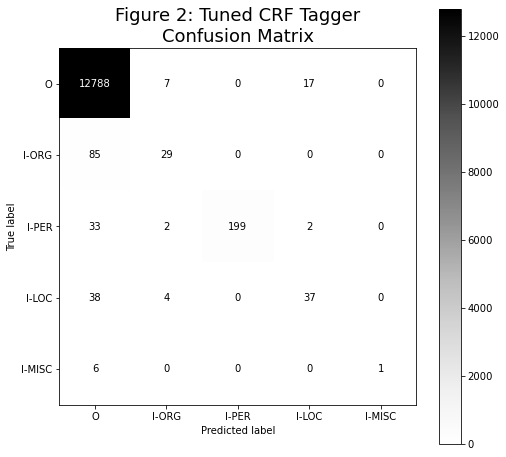

In [151]:
def create_confusion_matrix(model, X, y):

    y_pred = model.predict(X)
    ner_labels = model.classes_

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    true = [label for sent_list in y for label in sent_list]
    pred = [label for sent_list in y_pred for label in sent_list]

    cm = confusion_matrix(true, pred, ner_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ner_labels)
    disp.plot(cmap = 'Greys', ax = ax)

    plt.title('Figure 2: Tuned CRF Tagger\nConfusion Matrix', fontdict={'fontsize' : 18})

    plt.savefig('./crf_confusion_matrix.png')

    plt.show()

create_confusion_matrix(
    model = tuned_crf,
    X = X_test,
    y = test_labels_ner
)

In [25]:
print(flat_classification_report(
    y_true=test_labels_ner,
    y_pred=tuned_crf.predict(X_test),
    labels = ['I-ORG', 'I-PER', 'I-LOC', 'I-MISC']
))

              precision    recall  f1-score   support

       I-ORG       0.69      0.25      0.37       114
       I-PER       1.00      0.84      0.91       236
       I-LOC       0.66      0.47      0.55        79
      I-MISC       1.00      0.14      0.25         7

   micro avg       0.89      0.61      0.72       436
   macro avg       0.84      0.43      0.52       436
weighted avg       0.86      0.61      0.70       436



### Eli5

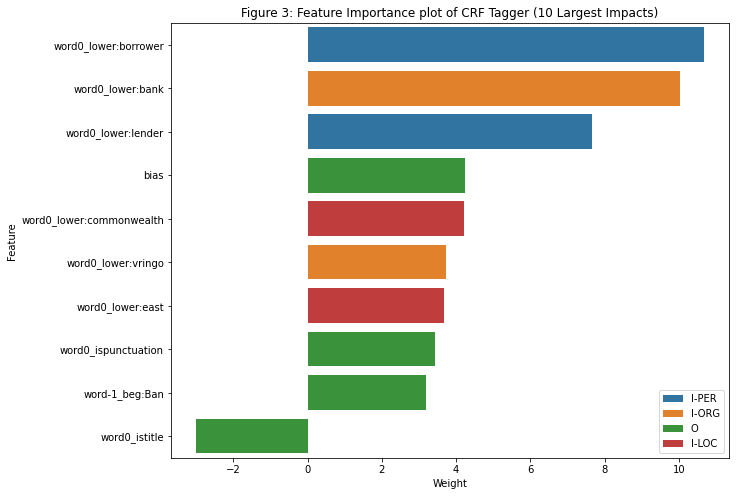

In [26]:
test = eli5.formatters.explain_weights_dfs(tuned_crf)['targets']
test['weight_sort'] = abs(test['weight'])
test = test.nlargest(10, columns = 'weight_sort')

fig, ax = plt.subplots(1,1, figsize = (10, 8))

sns.barplot(
    ax = ax,
    data = test,
    y = 'feature',
    x = 'weight',
    hue = 'target',
    dodge=False
)
plt.legend(loc = 'lower right')
plt.title('Figure 3: Feature Importance plot of CRF Tagger (10 Largest Impacts)')
plt.ylabel('Feature')
plt.xlabel('Weight')
plt.show()

## Financial Phrasebank

In [32]:
(train_sentences_fp, test_sentences_fp, val_sentences_fp, train_labels_fp, test_labels_fp, val_labels_fp,
    ) = data_loader.import_task1_data()

sentences_fp = train_sentences_fp + test_sentences_fp + val_sentences_fp
labels_fp = train_labels_fp + test_labels_fp + val_labels_fp

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 29.00it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})
How many instances in the train dataset? 

3876

What does one instance look like? 

The Lemminkainen Group , headquartered in Helsinki , Finland , operates in all sectors of the construction industry : civil engineering , building contracting , technical building services and the building materials industry .
instances in the validation dataset 

969

instances in the test dataset 

970


### Process Data

In [33]:
def vectorise_data(lst):

    return [nltk.word_tokenize(sentence) for sentence in lst]

In [34]:
sentences_fp = vectorise_data(sentences_fp)

In [35]:
labels_sent_scores = list(map(lambda x: {0: -1, 1: 0, 2: 1}[x], labels_fp))

In [36]:
sentences_fp_pp = crf_data_preprocessing(sentences_fp)

data: 4846 out: 4846


In [37]:
fp_preds = tuned_crf.predict(sentences_fp_pp)

In [145]:
fp_preds_and_scores = []

for sentence, labels, sentiment in zip(sentences_fp, fp_preds, labels_sent_scores):

    sentence_info = []

    for word, label in zip(sentence, labels):

        if sentence_info == []:

            sentence_info.append([word, label, sentiment])

        elif sentence_info[-1][1] == label:

            sentence_info[-1][0] += ' ' + word

        else:
            
            sentence_info.append([word, label, sentiment])

    if len(sentence_info) > 2:
        fp_preds_and_scores.append(sentence_info)

for sentence in fp_preds_and_scores:

    for breaks in sentence:

        if breaks[1] == 'O':

            sentence.remove(breaks)

In [146]:
scores = {}
for entry in fp_preds_and_scores:

    word, lab, sent = entry[0][0], entry[0][1], entry[0][2]

    if lab == 'I-ORG':
        if word in scores.keys():
            scores[word] += sent
        else:
            scores[word] = sent

In [149]:
for k in sorted(scores, key = scores.get, reverse=True)[:5]:

    print(k, scores[k])

for k in sorted(scores, key = scores.get, reverse=False)[:5]:

    print(k, scores[k])

Bank 5
Suominen Corporation 4
Nokia Siemens Networks 2
Incap Corporation of Finland 1
KONE Corporation 1
Raute Corporation -1
Marimekko Corporation -1
Rapala VMC Corporation STOCK EXCHANGE RELEASE October -1
Burrill Life Sciences Capital Fund -1
bank -1
